In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
datafolder = '../data/aeronef'

## Airfoil geometry

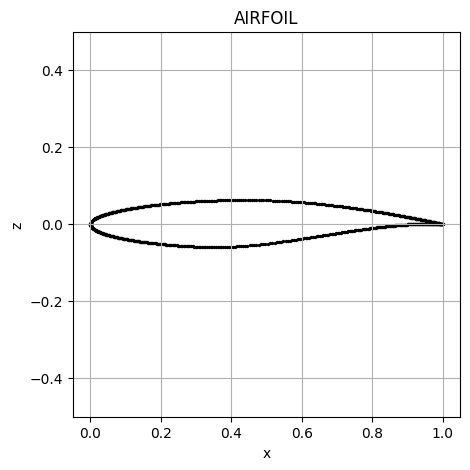

In [4]:
file = 'airfoil.npy'
airfoil_coords = np.load(os.path.join(datafolder, file))


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
sc = ax.scatter(x=airfoil_coords[:,0], y=airfoil_coords[:,1], s=2, c='black')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_ylim(bottom=-0.5, top=0.5)
ax.set_title('AIRFOIL')
ax.grid()


## Randomly sampled dataset

In [5]:
file_name = 'db_random.npy'
cyc = np.load(os.path.join(datafolder, file_name), allow_pickle=True).item()

# M=cyc['Mach']
# cyc['Cp_field'] = (2/(1.4*M))*(1-(1+0.2*M**2)**(0.4/1.4))

# normalize x and y
x_min, x_max = cyc['Xcoordinate'].min(axis=1).reshape(-1, 1), cyc['Xcoordinate'].max(axis=1).reshape(-1, 1)
y_min, y_max = cyc['Ycoordinate'].min(axis=1).reshape(-1, 1), cyc['Ycoordinate'].max(axis=1).reshape(-1, 1)
cyc['Xcoordinate'] = (cyc['Xcoordinate'] - x_min) / (x_max - x_min)
cyc['Ycoordinate'] = (cyc['Ycoordinate'] - y_min) / (y_max - y_min)

for key in cyc.keys():
    print(f'Clave: {key}. Shape: {cyc[key].shape}')

Clave: idx. Shape: (1007,)
Clave: Alpha. Shape: (1007,)
Clave: Vinf. Shape: (1007,)
Clave: Cl. Shape: (1007,)
Clave: Cd. Shape: (1007,)
Clave: Cm. Shape: (1007,)
Clave: Cp. Shape: (1007, 691)
Clave: Cf. Shape: (1007, 691)
Clave: Xcoordinate. Shape: (1007, 27499)
Clave: Ycoordinate. Shape: (1007, 27499)
Clave: Pressure. Shape: (1007, 27499)
Clave: Mach. Shape: (1007, 27499)
Clave: Vmag. Shape: (1007, 27499)
Clave: Temperature. Shape: (1007, 27499)
Clave: Vx. Shape: (1007, 27499)
Clave: Vy. Shape: (1007, 27499)
Clave: Airfoil. Shape: (691, 2)


## Different flight conditions

Text(0, 0.5, 'Vinf')

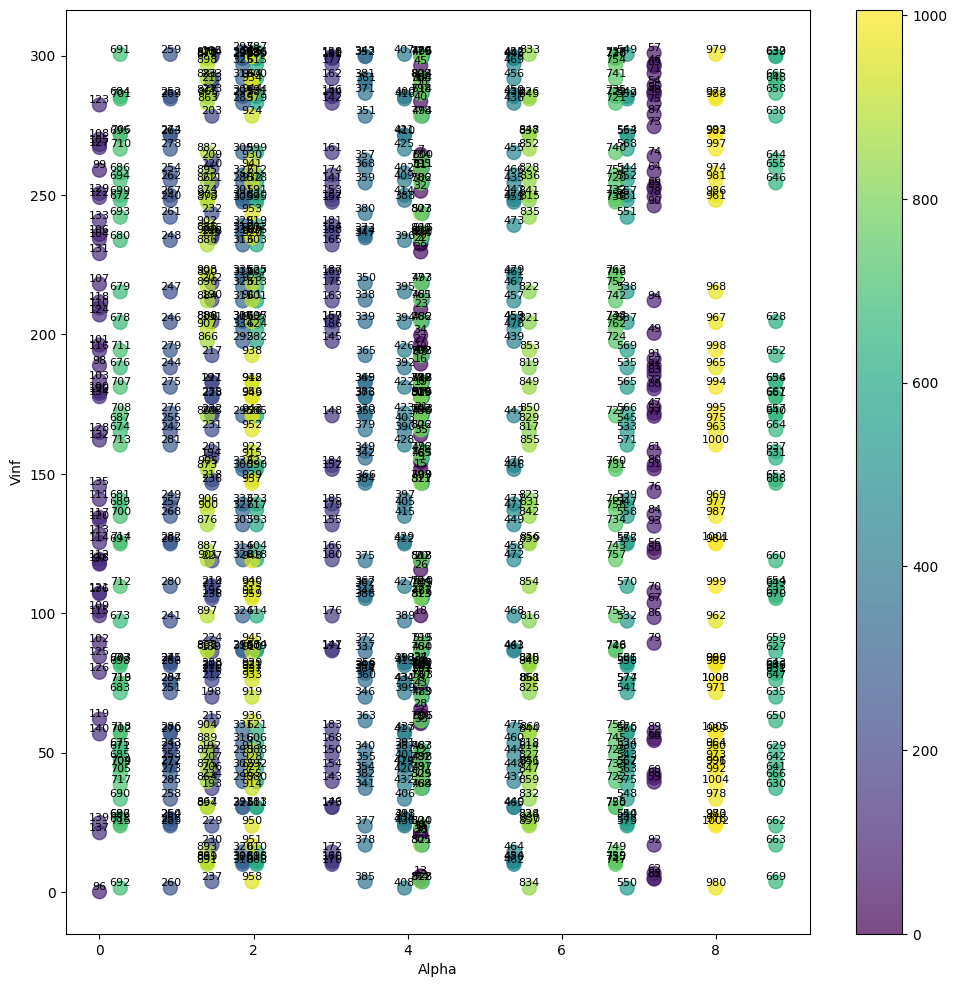

In [6]:
plt.figure(figsize=(12,12))
sc = plt.scatter(cyc['Alpha'], cyc['Vinf'], c=range(len(cyc['Alpha'])), s=100, cmap='viridis', alpha=0.7)
for i, (x, y) in enumerate(zip(cyc['Alpha'], cyc['Vinf'])):
    plt.text(x, y+0.005, str(i), fontsize=8, color='black', ha='center', va='bottom')

plt.colorbar(sc)
plt.xlabel('Alpha')
plt.ylabel('Vinf')

### Plot a single sample

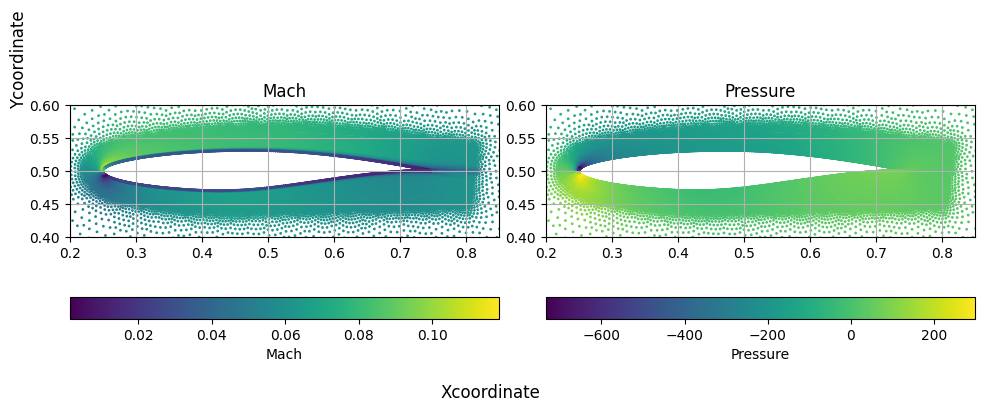

In [7]:
idx = 0
var_list = ['Mach', 'Pressure'] # ['Pressure', 'Mach', 'Temperature', 'Cp_field']
cmaps = ['viridis', 'viridis'] # ['viridis', 'jet', 'plasma', 'viridis']

fig, axes = plt.subplots(nrows=1, ncols=len(var_list), figsize=(5*len(var_list), 7), sharex=True)
axes = axes.flatten()
for ax, key, cmap in zip(axes, var_list, cmaps):
    sc = ax.scatter(
        x=cyc['Xcoordinate'][idx, :],
        y=cyc['Ycoordinate'][idx, :],
        s=1,
        c=cyc[key][idx, :],
        cmap=cmap
    )
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
    cbar.set_label(key)

    ax.set_title(key)
    ax.grid(True)
    ax.set_xlim((0.2, 0.85))
    ax.set_ylim((0.4, 0.6))
    ax.set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio
    # sc = ax.scatter(x=airfoil[:,0], y=airfoil[:,1], s=2, c='black')
    # ax.set_xlabel('x')
    # ax.set_ylabel('z')
    # ax.set_title('AIRFOIL')

fig.supxlabel('Xcoordinate')
fig.supylabel('Ycoordinate')

plt.tight_layout()
plt.show()

## Process the meshes to get a structured dataset

In [8]:
import numpy as np
from scipy.interpolate import griddata
from matplotlib.path import Path
from tqdm.auto import tqdm

def cfd_to_structured_grid(
    x_coords, 
    y_coords, 
    pressure, 
    airfoil_coords,
    grid_resolution=(128, 128),
    x_range=(0, 1),
    y_range=(0, 1),
    fill_value=0.0,
    airfoil_method='hardcoded',
    preserve_aspect_ratio=False
):
    """
    Convert unstructured CFD mesh data to structured grid with airfoil masking.
    
    Parameters:
    -----------
    x_coords : np.ndarray
        X coordinates of mesh points, shape (N_samples, n_points)
    y_coords : np.ndarray
        Y coordinates of mesh points, shape (N_samples, n_points)
    pressure : np.ndarray
        Pressure values at mesh points, shape (N_samples, n_points)
    airfoil_coords : np.ndarray
        Airfoil coordinates, shape (n_airfoil_points, 2) where [:, 0] is x and [:, 1] is y
        Expected to have x in [0, 1] but y may need scaling
    grid_resolution : tuple
        Output grid resolution (height, width), default (128, 128)
    x_range : tuple
        Range for x-axis in output grid, default (0, 1)
    y_range : tuple
        Range for y-axis in output grid, default (0, 1)
    fill_value : float
        Value to use for points inside the airfoil, default 0.0
    airfoil_method : str
        Method for airfoil detection: 'hardcoded', 'boundary_detection', or 'density'
        'hardcoded' uses known leading edge at (0.25, 0.5) and trailing edge at (0.75, 0.5)
    preserve_aspect_ratio : bool
        If True, preserve airfoil aspect ratio. If False, scale to fit detected region.
        (Only used for non-hardcoded methods)
        
    Returns:
    --------
    structured_data : np.ndarray
        Interpolated pressure on structured grid, shape (N_samples, height, width)
    airfoil_mask : np.ndarray
        Binary mask where 1=fluid region, 0=inside airfoil, shape (height, width)
    grid_x : np.ndarray
        X coordinates of structured grid
    grid_y : np.ndarray
        Y coordinates of structured grid
    scaled_airfoil : np.ndarray
        Airfoil coordinates scaled to match mesh coordinate system
    """
    
    n_samples = x_coords.shape[0]
    height, width = grid_resolution
    
    # Step 1: Scale airfoil to match mesh coordinate system
    # Using hardcoded leading edge at (0.25, 0.5) and trailing edge at (0.75, 0.5)
    scaled_airfoil = _scale_airfoil_to_mesh(
        x_coords[0], y_coords[0], airfoil_coords, 
        method=airfoil_method,
        preserve_aspect_ratio=preserve_aspect_ratio
    )
    
    # Step 2: Create structured grid
    grid_x = np.linspace(x_range[0], x_range[1], width)
    grid_y = np.linspace(y_range[0], y_range[1], height)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
    
    # Step 3: Create airfoil mask (points inside airfoil = 0, outside = 1)
    airfoil_mask = _create_airfoil_mask(grid_xx, grid_yy, scaled_airfoil)
    
    # Step 4: Interpolate each sample to structured grid
    structured_data = np.zeros((n_samples, height, width))
    
    for i in tqdm(range(n_samples), desc="Interpolating samples"):
        # Get valid points (not NaN)
        valid_mask = ~(np.isnan(x_coords[i]) | np.isnan(y_coords[i]) | np.isnan(pressure[i]))
        
        if np.sum(valid_mask) == 0:
            continue
            
        points = np.column_stack([
            x_coords[i, valid_mask],
            y_coords[i, valid_mask]
        ])
        values = pressure[i, valid_mask]
        
        # Interpolate to grid
        grid_points = np.column_stack([grid_xx.ravel(), grid_yy.ravel()])
        interpolated = griddata(
            points, 
            values, 
            grid_points, 
            method='linear',
            fill_value=np.nan
        )
        interpolated = interpolated.reshape(height, width)
        
        # Fill NaN values with nearest neighbor
        if np.any(np.isnan(interpolated)):
            nan_mask = np.isnan(interpolated)
            interpolated_nn = griddata(
                points,
                values,
                grid_points,
                method='nearest'
            ).reshape(height, width)
            interpolated[nan_mask] = interpolated_nn[nan_mask]
        
        # Apply airfoil mask
        interpolated[airfoil_mask == 0] = fill_value
        
        structured_data[i] = interpolated
    
    return structured_data, airfoil_mask, grid_xx, grid_yy, scaled_airfoil


def _scale_airfoil_to_mesh(x_mesh, y_mesh, airfoil_coords, method='hardcoded', preserve_aspect_ratio=True):
    """
    Scale and position airfoil coordinates to match mesh coordinate system.
    
    Parameters:
    -----------
    x_mesh : np.ndarray
        X coordinates of mesh points
    y_mesh : np.ndarray
        Y coordinates of mesh points
    airfoil_coords : np.ndarray
        Airfoil coordinates to scale
    method : str
        'hardcoded' - use known leading/trailing edge positions (recommended)
        'boundary_detection' - detect airfoil from mesh boundary
        'density' - use point density heuristic (fallback)
    preserve_aspect_ratio : bool
        If True, use same scale for x and y (based on x-scale)
        If False, scale x and y independently to fit detected region
    
    Strategy: Scale airfoil to match known positions in mesh.
    Leading edge at (0.25, 0.5), trailing edge at (0.75, 0.5).
    """
    airfoil_x = airfoil_coords[:, 0]
    airfoil_y = airfoil_coords[:, 1]
    
    if method == 'hardcoded':
        # Known positions in mesh
        mesh_leading_edge = np.array([0.25, 0.5])
        mesh_trailing_edge = np.array([0.75, 0.5])
        
        # Find leading and trailing edges in airfoil coordinates
        # Leading edge is typically at minimum x
        le_idx = np.argmin(airfoil_x)
        # Trailing edge is typically at maximum x
        te_idx = np.argmax(airfoil_x)
        
        airfoil_leading_edge = airfoil_coords[le_idx]
        airfoil_trailing_edge = airfoil_coords[te_idx]
        
        # Calculate chord length in both coordinate systems
        mesh_chord = np.linalg.norm(mesh_trailing_edge - mesh_leading_edge)
        airfoil_chord = np.linalg.norm(airfoil_trailing_edge - airfoil_leading_edge)
        
        # Scale factor
        scale = mesh_chord / airfoil_chord
        
        # Center of airfoil
        airfoil_center = (airfoil_leading_edge + airfoil_trailing_edge) / 2
        mesh_center = (mesh_leading_edge + mesh_trailing_edge) / 2
        
        # Scale and translate
        scaled_x = (airfoil_x - airfoil_center[0]) * scale + mesh_center[0]
        scaled_y = (airfoil_y - airfoil_center[1]) * scale + mesh_center[1]
        
        scaled_airfoil = np.column_stack([scaled_x, scaled_y])
        
        return scaled_airfoil
    
    # Remove any NaN values for other methods
    valid = ~(np.isnan(x_mesh) | np.isnan(y_mesh))
    x_mesh = x_mesh[valid]
    y_mesh = y_mesh[valid]
    
    if method == 'boundary_detection':
        # Create a 2D histogram to find low-density regions (airfoil interior)
        H, x_edges, y_edges = np.histogram2d(x_mesh, y_mesh, bins=[100, 50])
        
        # Find the region with very low density (likely airfoil interior)
        threshold = np.percentile(H[H > 0], 5)  # Bottom 5% of non-zero bins
        low_density_mask = (H < threshold) & (H >= 0)
        
        # Find connected low-density region (should be the airfoil)
        from scipy import ndimage
        labeled, num_features = ndimage.label(low_density_mask)
        
        if num_features > 0:
            # Find the largest low-density region
            sizes = ndimage.sum(low_density_mask, labeled, range(1, num_features + 1))
            largest_region = np.argmax(sizes) + 1
            airfoil_region = (labeled == largest_region)
            
            # Get bounding box of this region
            y_indices, x_indices = np.where(airfoil_region)
            if len(x_indices) > 0:
                # Fix index bounds - ensure we don't go out of range
                mesh_x_min = x_edges[x_indices.min()]
                mesh_x_max = x_edges[min(x_indices.max() + 1, len(x_edges) - 1)]
                mesh_y_min = y_edges[y_indices.min()]
                mesh_y_max = y_edges[min(y_indices.max() + 1, len(y_edges) - 1)]
                
                mesh_x_center = (mesh_x_min + mesh_x_max) / 2
                mesh_y_center = (mesh_y_min + mesh_y_max) / 2
                mesh_x_range = mesh_x_max - mesh_x_min
                mesh_y_range = mesh_y_max - mesh_y_min
            else:
                # Fallback to density method
                return _scale_airfoil_to_mesh(x_mesh, y_mesh, airfoil_coords, method='density')
        else:
            # Fallback to density method
            return _scale_airfoil_to_mesh(x_mesh, y_mesh, airfoil_coords, method='density')
    
    else:  # density method (original approach)
        # Find x-range where points are most concentrated
        x_bins = np.linspace(0, 1, 50)
        hist, _ = np.histogram(x_mesh, bins=x_bins)
        
        dense_region = hist > np.percentile(hist, 75)
        
        if np.any(dense_region):
            dense_indices = np.where(dense_region)[0]
            x_min_idx = dense_indices[0]
            x_max_idx = dense_indices[-1]
            mesh_x_min = x_bins[x_min_idx]
            mesh_x_max = x_bins[x_max_idx + 1]
        else:
            mesh_x_min = 0.2
            mesh_x_max = 0.85
        
        mesh_x_center = (mesh_x_min + mesh_x_max) / 2
        mesh_x_range = mesh_x_max - mesh_x_min
        
        # For y-coordinates, find the central region
        y_points_in_x_range = y_mesh[(x_mesh >= mesh_x_min) & (x_mesh <= mesh_x_max)]
        
        if len(y_points_in_x_range) > 0:
            mesh_y_center = np.median(y_points_in_x_range)
            mesh_y_range = np.percentile(y_points_in_x_range, 90) - np.percentile(y_points_in_x_range, 10)
        else:
            mesh_y_center = 0.5
            mesh_y_range = 0.2
    
    # Calculate airfoil extents
    airfoil_x_min = np.min(airfoil_x)
    airfoil_x_max = np.max(airfoil_x)
    airfoil_y_min = np.min(airfoil_y)
    airfoil_y_max = np.max(airfoil_y)
    
    airfoil_x_center = (airfoil_x_min + airfoil_x_max) / 2
    airfoil_y_center = (airfoil_y_min + airfoil_y_max) / 2
    airfoil_x_range = airfoil_x_max - airfoil_x_min
    airfoil_y_range = airfoil_y_max - airfoil_y_min
    
    # Calculate scale
    if preserve_aspect_ratio:
        # Use x-direction scale to preserve aspect ratio
        scale = mesh_x_range / airfoil_x_range
        scaled_x = (airfoil_x - airfoil_x_center) * scale + mesh_x_center
        scaled_y = (airfoil_y - airfoil_y_center) * scale + mesh_y_center
    else:
        # Scale x and y independently to match detected region
        scale_x = mesh_x_range / airfoil_x_range
        scale_y = mesh_y_range / airfoil_y_range
        scaled_x = (airfoil_x - airfoil_x_center) * scale_x + mesh_x_center
        scaled_y = (airfoil_y - airfoil_y_center) * scale_y + mesh_y_center
    
    scaled_airfoil = np.column_stack([scaled_x, scaled_y])
    
    return scaled_airfoil


def _create_airfoil_mask(grid_xx, grid_yy, airfoil_coords):
    """
    Create binary mask: 1 for fluid region, 0 for inside airfoil.
    """
    # Create path from airfoil coordinates (should be closed loop)
    airfoil_path = Path(airfoil_coords)
    
    # Test all grid points
    grid_points = np.column_stack([grid_xx.ravel(), grid_yy.ravel()])
    inside = airfoil_path.contains_points(grid_points)
    
    # Reshape to grid
    mask = (~inside).astype(float).reshape(grid_xx.shape)
    
    return mask


def visualize_results(
    x_coords,
    y_coords,
    pressure,
    structured_data,
    airfoil_mask,
    grid_xx,
    grid_yy,
    scaled_airfoil,
    sample_idx=0,
    figsize=(16, 10)
):
    """
    Visualize the conversion results with comparison plots.
    
    Parameters:
    -----------
    x_coords : np.ndarray
        Original x coordinates, shape (N_samples, n_points)
    y_coords : np.ndarray
        Original y coordinates, shape (N_samples, n_points)
    pressure : np.ndarray
        Original pressure values, shape (N_samples, n_points)
    structured_data : np.ndarray
        Interpolated structured data, shape (N_samples, height, width)
    airfoil_mask : np.ndarray
        Binary mask, shape (height, width)
    grid_xx : np.ndarray
        X coordinates of structured grid
    grid_yy : np.ndarray
        Y coordinates of structured grid
    scaled_airfoil : np.ndarray
        Scaled airfoil coordinates, shape (n_airfoil, 2)
    sample_idx : int
        Which sample to visualize, default 0
    figsize : tuple
        Figure size, default (16, 10)
    """
    import matplotlib.pyplot as plt
    from matplotlib.tri import Triangulation
    
    fig = plt.figure(figsize=figsize)
    
    # Get data for the selected sample
    x_sample = x_coords[sample_idx]
    y_sample = y_coords[sample_idx]
    p_sample = pressure[sample_idx]
    
    # Remove NaN values
    valid = ~(np.isnan(x_sample) | np.isnan(y_sample) | np.isnan(p_sample))
    x_sample = x_sample[valid]
    y_sample = y_sample[valid]
    p_sample = p_sample[valid]
    
    # Determine color range for consistent comparison
    vmin = np.nanmin(p_sample)
    vmax = np.nanmax(p_sample)
    
    # Plot 1: Original unstructured mesh
    ax1 = plt.subplot(2, 3, 1)
    scatter = ax1.scatter(x_sample, y_sample, c=p_sample, s=1, cmap='jet', vmin=vmin, vmax=vmax)
    ax1.plot(scaled_airfoil[:, 0], scaled_airfoil[:, 1], 'k-', linewidth=0.5, label='Scaled airfoil')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'Original Unstructured Mesh (Sample {sample_idx})')
    ax1.set_aspect('equal')
    ax1.legend()
    plt.colorbar(scatter, ax=ax1, label='Pressure')
    
    # Plot 2: Original mesh with triangulation
    ax2 = plt.subplot(2, 3, 2)
    try:
        triang = Triangulation(x_sample, y_sample)
        tcf = ax2.tricontourf(triang, p_sample, levels=20, cmap='jet', vmin=vmin, vmax=vmax)
        ax2.plot(scaled_airfoil[:, 0], scaled_airfoil[:, 1], 'k-', linewidth=0.5)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_title('Original Data (Triangulated)')
        ax2.set_aspect('equal')
        plt.colorbar(tcf, ax=ax2, label='Pressure')
    except:
        ax2.text(0.5, 0.5, 'Triangulation failed', ha='center', va='center', transform=ax2.transAxes)
    
    # Plot 3: Structured grid result
    ax3 = plt.subplot(2, 3, 3)
    im = ax3.imshow(structured_data[sample_idx], extent=[grid_xx.min(), grid_xx.max(), 
                                                          grid_yy.min(), grid_yy.max()],
                    origin='lower', cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
    ax3.plot(scaled_airfoil[:, 0], scaled_airfoil[:, 1], 'k-', linewidth=0.5)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_title('Structured Grid (Interpolated)')
    ax3.set_aspect('equal')
    plt.colorbar(im, ax=ax3, label='Pressure')
    
    # Plot 4: Airfoil mask
    ax4 = plt.subplot(2, 3, 4)
    im_mask = ax4.imshow(airfoil_mask, extent=[grid_xx.min(), grid_xx.max(), 
                                                grid_yy.min(), grid_yy.max()],
                         origin='lower', cmap='gray', aspect='auto')
    ax4.plot(scaled_airfoil[:, 0], scaled_airfoil[:, 1], 'r-', linewidth=2)
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_title('Airfoil Mask (1=fluid, 0=airfoil)')
    ax4.set_aspect('equal')
    plt.colorbar(im_mask, ax=ax4)
    
    # Plot 5: Structured grid with mask overlay
    ax5 = plt.subplot(2, 3, 5)
    im2 = ax5.imshow(structured_data[sample_idx], extent=[grid_xx.min(), grid_xx.max(), 
                                                           grid_yy.min(), grid_yy.max()],
                     origin='lower', cmap='jet', vmin=vmin, vmax=vmax, aspect='auto')
    # Overlay mask boundary
    ax5.contour(grid_xx, grid_yy, airfoil_mask, levels=[0.5], colors='black', linewidths=0.5)
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_title('Structured Grid with Mask Boundary')
    ax5.set_aspect('equal')
    plt.colorbar(im2, ax=ax5, label='Pressure')
    
    # Plot 6: Difference/Quality check - point density
    ax6 = plt.subplot(2, 3, 6)
    hist, xedges, yedges = np.histogram2d(x_sample, y_sample, bins=50)
    im_hist = ax6.imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                         origin='lower', cmap='hot', aspect='auto')
    ax6.plot(scaled_airfoil[:, 0], scaled_airfoil[:, 1], 'cyan', linewidth=2)
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_title('Original Mesh Point Density')
    ax6.set_aspect('equal')
    plt.colorbar(im_hist, ax=ax6, label='Point count')
    
    plt.tight_layout()
    return fig


In [9]:
x_mesh = np.array(cyc['Xcoordinate'], dtype=np.float32) 
y_mesh = np.array(cyc['Ycoordinate'], dtype=np.float32)
pressure_data = np.array(cyc['Pressure'], dtype=np.float32)

structured_pressure, mask, grid_x, grid_y, scaled_airfoil = cfd_to_structured_grid(
    x_coords=x_mesh,          # shape (N, n_points)
    y_coords=y_mesh,          # shape (N, n_points)
    pressure=pressure_data,   # shape (N, n_points)
    airfoil_coords=airfoil_coords,   # shape (n_airfoil, 2)
    grid_resolution=(256, 128),
    x_range=(0.2, 0.85),
    y_range=(0.4, 0.6),
)

Interpolating samples:   0%|          | 0/1007 [00:00<?, ?it/s]

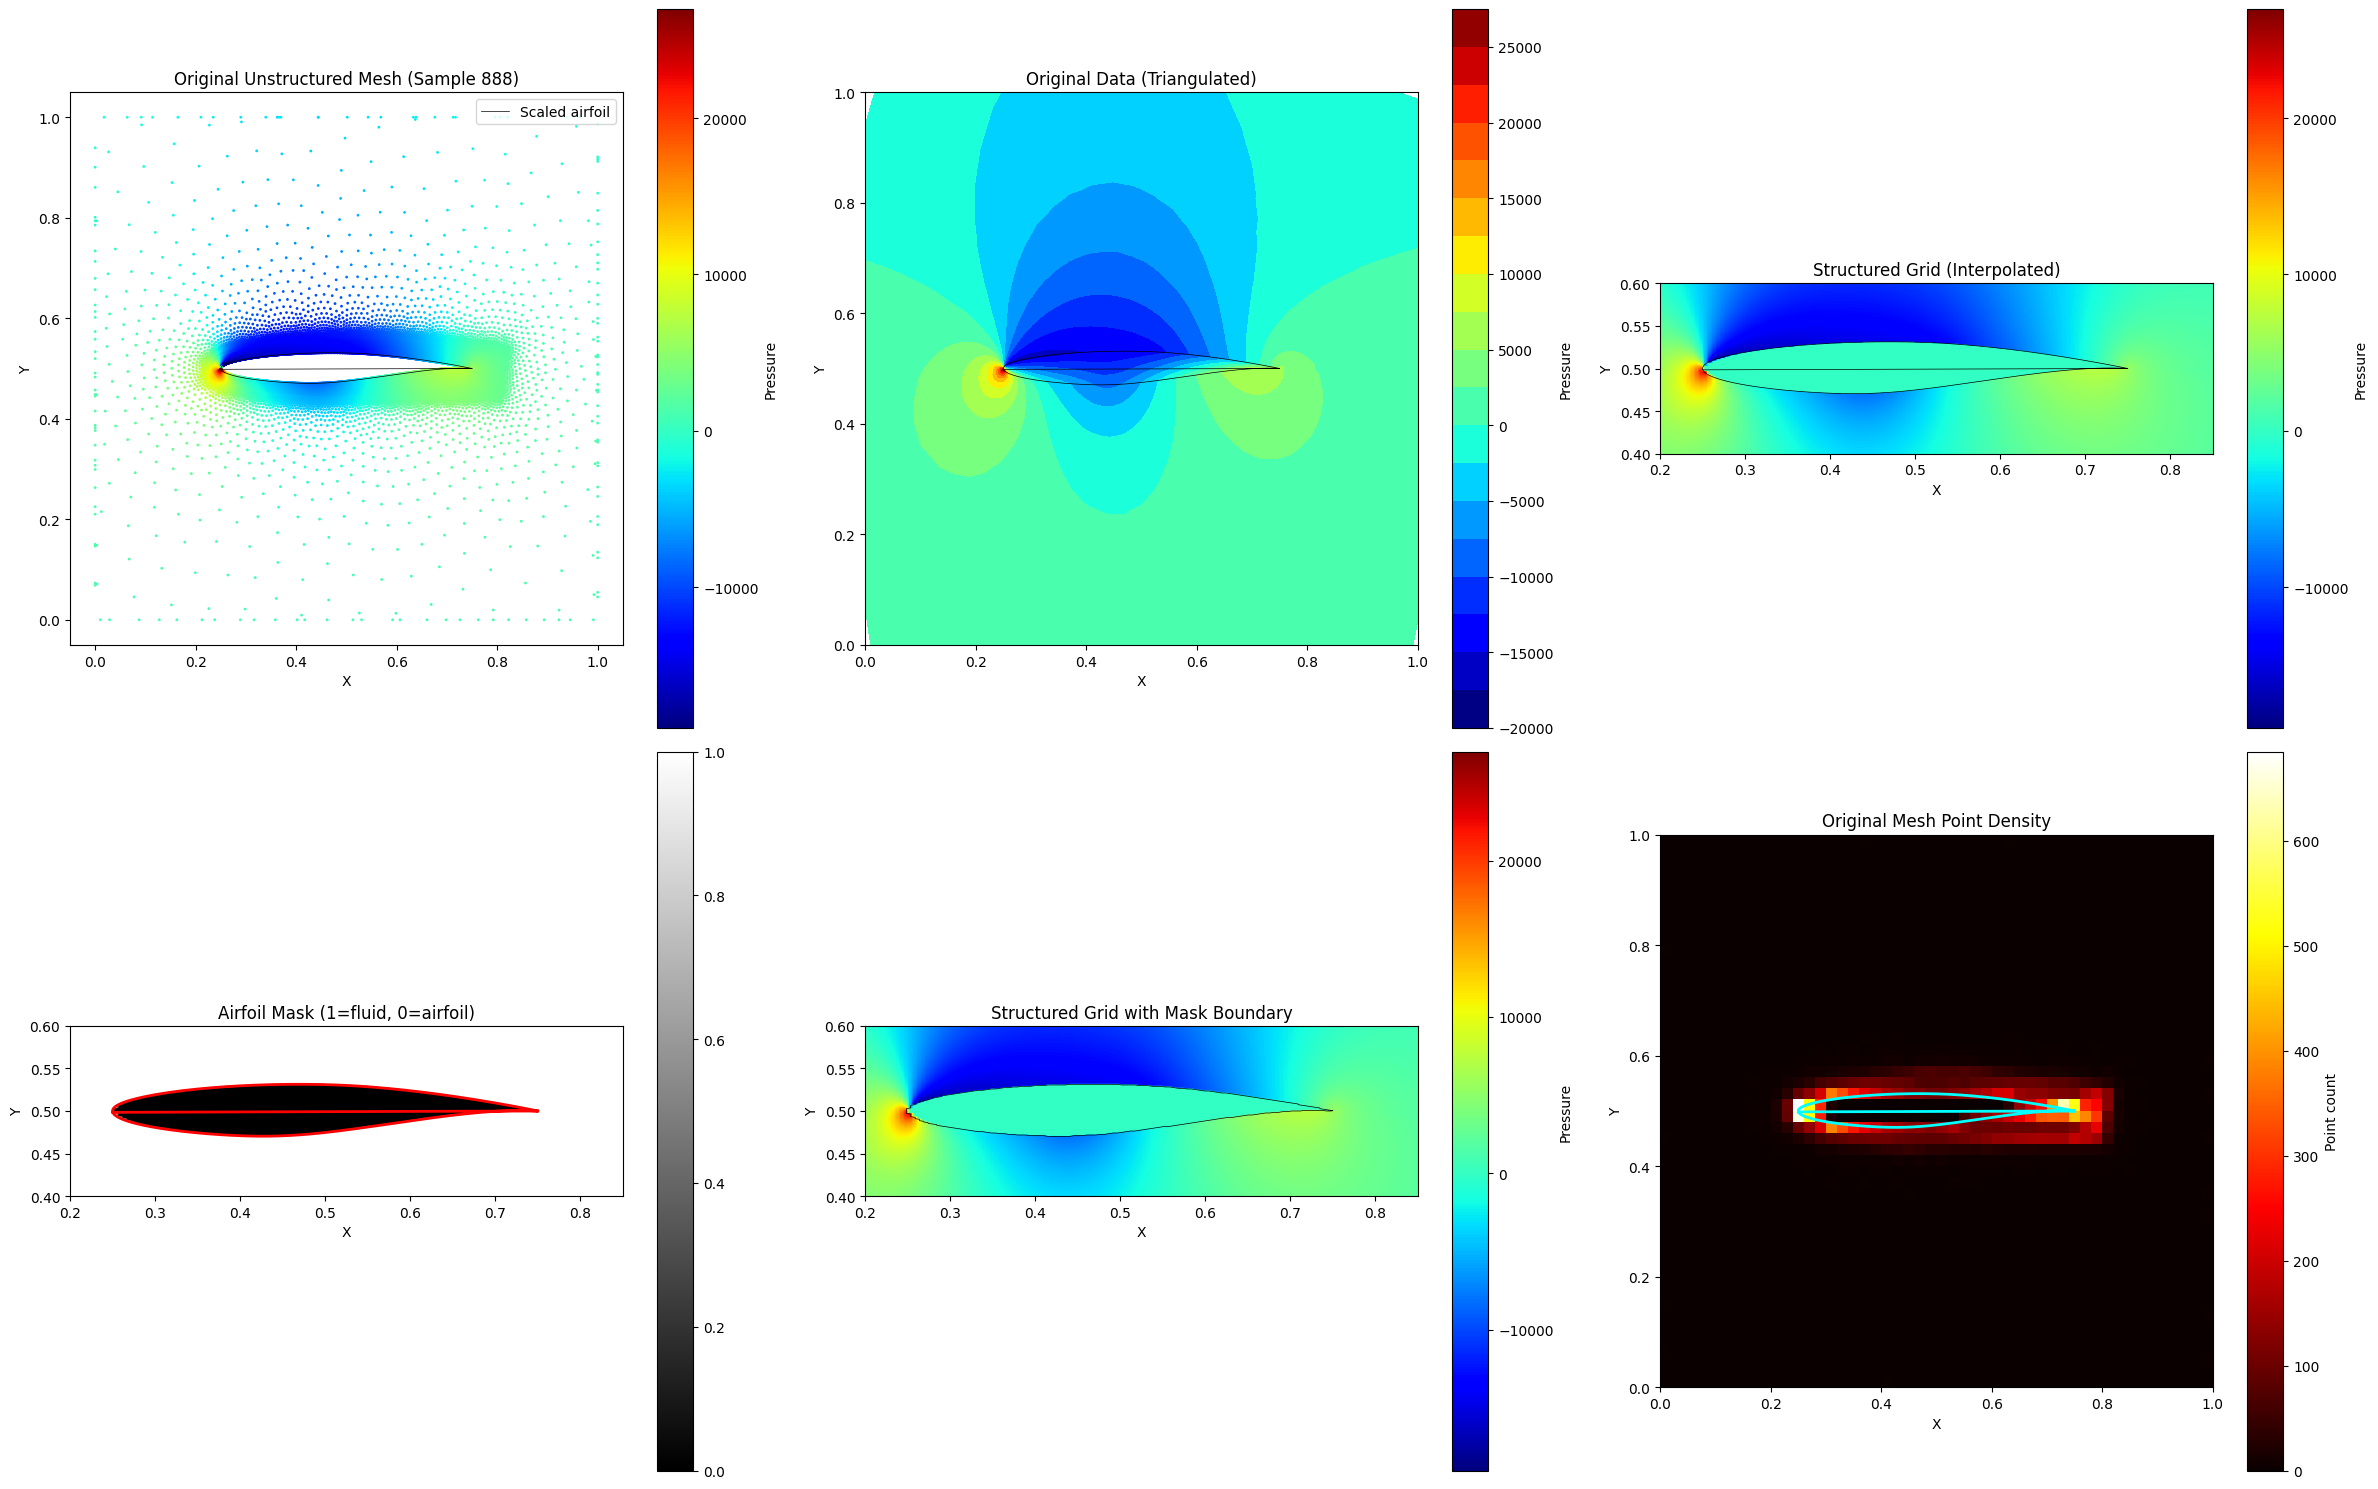

In [10]:
fig = visualize_results(
    x_mesh, y_mesh, pressure_data,
    structured_pressure, mask, grid_x, grid_y, scaled_airfoil,
    sample_idx=888, 
    figsize=(24, 15)
)
plt.show()

## Construct the dataset and make the split

Desired dataset shape --> (N_samples, 2, heigth, width)  
First channel: interpolated mesh with the points inside the airfoil filled with 0.  
Second channel: the mask with 1 and 0. 1 means point outside the airfoil and 0 means point inside the airfoil

In [11]:
structured_pressure[:, None, ...].shape, np.repeat(mask[None, None, ...], repeats=structured_pressure.shape[0], axis=0).shape

((1007, 1, 256, 128), (1007, 1, 256, 128))

In [12]:
dataset = np.concatenate(
    (structured_pressure[:, None, ...], np.repeat(mask[None, None, ...], repeats=structured_pressure.shape[0], axis=0)),
    axis=1
)
dataset.shape

(1007, 2, 256, 128)

In [13]:
flight_conditions = np.stack((cyc['Vinf'], cyc['Alpha']), axis=1)
flight_conditions.shape

(1007, 2)

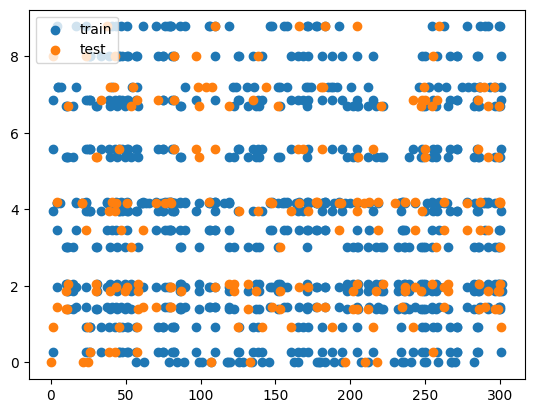

In [14]:
from sklearn.model_selection import train_test_split

seed = 42
dataset_train, dataset_test, flight_conditions_train, flight_conditions_test = train_test_split(
    dataset, flight_conditions, test_size=0.2, random_state=seed
)

plt.scatter(flight_conditions_train[:, 0], flight_conditions_train[:, 1], label="train")
plt.scatter(flight_conditions_test[:, 0], flight_conditions_test[:, 1], label="test")
plt.legend()
plt.show()

In [15]:
np.save('../data/aeronef/dataset_train.npy', dataset_train)
np.save('../data/aeronef/dataset_test.npy', dataset_test)
np.save('../data/aeronef/flight_conditions_train.npy', flight_conditions_train)
np.save('../data/aeronef/flight_conditions_test.npy', flight_conditions_test)